# Optimizing with Transparency

This tutorial notebook illustrates how to use Captum.optim to render RGBA images when using models trained only on RGB images.  This process is known as optimizing with transparency, and more information on it can be found at [the corresponding research paper](https://distill.pub/2018/differentiable-parameterizations/#section-rgba). As we will see below, optimizing with transparency yields important information about the saliency of feature visualizations that regular feature visualizations misses.

In [ ]:
!git clone https://github.com/pytorch/captum 
%cd captum
!git checkout "optim-wip"
!pip3 install -e .
import sys
sys.path.append('/content/captum')
%cd ..

import captum.optim as opt

In [ ]:
from typing import Callable, Tuple, List, Optional, Sequence, Union, Dict
import math
import torch
import torch.nn.functional as F

import captum.optim as opt
from captum.optim.models import googlenet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = googlenet(pretrained=True).to(device)

In additon to a visualization function, we'll define four main helper functions for this tutorial. The first function allows us to create distinct checkerboard backgrounds that let us easily see transparency, and the second function allows for the compositing of RGBA images onto backgrounds. The third function allows us to quickly view RGBA images on multiple distinct backgrounds. The fourth function simply allows us to graph the loss values from our rendering.

In [3]:
ModuleOutputMapping = Dict[torch.nn.Module, Optional[torch.Tensor]]

import matplotlib.pylab as plt


def visualize(
    model: torch.nn.Module,
    loss_fn: opt.loss.Loss,
    image: opt.images.ImageParameterization,
    transforms: Optional[Union[torch.nn.Module, List[torch.nn.Module]]] = None,
    n_iter: int = 512,
    lr: float = 0.01,
    return_image_instance: bool = False,
) -> Tuple[Union[opt.images.ImageParameterization, opt.images.ImageTensor], torch.Tensor]:
    """
    Helper function rendering results.

    Args:
        model (nn.Module): A PyTorch model instance.
        loss_function (callable): The loss function to minimize during optimization
            optimization.
        image (ImageParameterization): An image parameterization to render.
        transforms (nn.Module or list of nn.Module, optional): The transforms to use
            for optimization. If set to None then TransformationRobustness() is used.
            Default: None
        n_iter (int, optional):  Number of steps to run optimization for.
            Default: 512
        lr: (float, optional): If no optimizer is given, then lr is used as the
            learning rate for the Adam optimizer.
            Default: 0.01
        return_image_instance (bool, optional): Whether or not to return a detached
            tensor or the ImageParameterization instance.
            Default: False

    Returns:
        image (torch.Tensor or NaturalImage instance): The results of the rendering.
        history (torch.Tensor): The loss history for the rendering.
    """
    assert image().dim() == 4
    if transforms is None:
        transforms = opt.transforms.TransformationRobustness()
    transforms = (
        torch.nn.Sequential(*transforms)
        if isinstance(transforms, (list, tuple))
        else transforms
    )
    obj = opt.InputOptimization(model, loss_fn, image, transforms)
    history = obj.optimize(opt.optimization.n_steps(n_iter, True), lr=lr)
    if return_image_instance:
        return image, history
    else:
        return image().detach(), history


def create_checkerboard(
    size: Tuple[int, int],
    channels: int = 3,
    tiles: int = 4,
    colors: List[float] = [1.0, 0.0],
) -> torch.Tensor:
    """
    Create a checkerboard pattern.

    Based on Lucid's checkerboard function from here: https://github.com/tensorflow/
    lucid/blob/master/notebooks/differentiable-parameterizations/transparency.ipynb

    Args:

        size (Tuple[int, int]): The dimensions to use when creating the image, with a
            shape of: [H, W].
        channels (int, optional): The number of image channels to use for the output
            image.
            Default: 3
        tiles (int, optional): The number of tiles to create inside the image.
            Default: 4
        colors (list of float, optional): A list of colors to use for the
            checkerboard.
            Default: [1.0, 0.0]

    Returns:
        tensor (torch.Tensor): An NCHW image with a checkerboard pattern.
    """
    assert len(size) == 2 and len(colors) == 2

    square = torch.ones([math.ceil(float(d / tiles) / 2) for d in size])
    board = torch.tensor([colors * tiles, colors[::-1] * tiles] * tiles)
    scaled = torch.kron(board, square)[: size[0], : size[1]]
    return torch.stack([scaled] * channels)


def composite_alpha(
    x: torch.Tensor,
    background: torch.Tensor,
    gamma_to_linear: bool = False,
    linear_to_gamma: bool = True,
) -> torch.Tensor:
    """
    Composite an RGBA NCHW image tensor onto an NCHW image tensor background.

    See here for more details:
    https://en.wikipedia.org/wiki/Alpha_compositing
    https://en.wikipedia.org/wiki/Alpha_compositing#Gamma_correction

    Args:

        x (torch.Tensor): The RGBA image tensor with 4 channels in the format of NCHW.
        background (torch.Tensor): The background NCHW image tensor to use.
        gamma_to_linear (bool, optional): Whether or not to convert the alpha channel
            of the input image from gamma to a linear format.
            Default: False
        linear_to_gamma (bool, optional): Whether or not to convert the output image
            from linear to gamma format.
            Default: True

    Returns:
        image (torch.Tensor): The input image composited on top of the background.
    """
    assert x.dim() == 4 and x.shape[1] == 4
    assert background.dim() == 4
    assert x.device == background.device
    if gamma_to_linear:
        x[:, :3, ...] = x[:, :3, ...].clone() ** 2.2
    rgb, alpha_channel = x[:, :3, ...], x[:, 3:, ...]
    image = background * (1.0 - alpha_channel) + rgb * alpha_channel
    if linear_to_gamma:
        image = image ** (1.0 / 2.2)
    return image


def create_mosaic(
    img: torch.Tensor,
    background: Optional[torch.Tensor] = None,
    num_tiles: int = 4,
    gamma_to_linear: bool = False,
    linear_to_gamma: bool = True,
) -> torch.Tensor:
    """
    Composite an NCHW RGBA image tensor onto 4 distinct backgrounds;
    no background, checkerboard, white, and black backgrounds.

    Args:

        img (torch.Tensor): An RGBA NCHW image tensor.
        background (torch.Tensor, optional): An NCHW image tensor to use as a
             background for the img input. If set to None, then a checkerboard
             background will be used.
             Default: None
        tiles (int, optional): The number of tiles to use for the checkerboard
            background image. This variable is only used if background is set to None.
            Default: 4
        gamma_to_linear (bool, optional): Whether or not to convert the alpha channel
            of the input image from gamma to a linear format.
            Default: False
        linear_to_gamma (bool, optional): Whether or not to convert the output image
            from linear to gamma format.
            Default: True

    Returns:
        mosaic_tensor (torch.Tensor): An NCHW image mosaic showing the img
            input on different backgrounds.
    """
    assert img.dim() == 4 and img.shape[1] == 4
    img_list = [img[:, :3]]

    # Place visualizations on top of custom or checkerboard image
    if background is None:
        background = create_checkerboard(img.shape[2:], tiles=num_tiles).unsqueeze(0).to(img.device)

    img_list.append(
        composite_alpha(img, background,
        gamma_to_linear=gamma_to_linear,
        linear_to_gamma=linear_to_gamma)
    )

    # Place visualization on white background
    img_list.append(
        composite_alpha(
            img,
            torch.ones_like(img[:, :3]),
            gamma_to_linear=gamma_to_linear,
            linear_to_gamma=linear_to_gamma,
        )
    )

    # Place visualization on black background
    img_list.append(
        composite_alpha(
            img,
            torch.zeros_like(img[:, :3]),
            gamma_to_linear=gamma_to_linear,
            linear_to_gamma=linear_to_gamma,
        )
    )
    return torch.cat(img_list)


def composite_alpha_only(x: torch.Tensor) -> torch.Tensor:
    """
    Visualize the alphs channel of an NCHW RGBA image tensor.

    Args:

        x (torch.Tensor): An RGBA NCHW image tensor.

    Returns:
        x (torch.Tensor): An RGB NCHW image tensor for the 4th input image channel.
    """
    assert x.dim() == 4 and x.shape[1] == 4
    return torch.ones_like(x[:, :3]) * x[:, 3:]


def plot_loss(
    history: Union[torch.Tensor, List[torch.Tensor]],
    figsize: Optional[Union[Tuple[int, int], Tuple[float, float]]] = None,
    title: Optional[str] = None,
    labels: Optional[List[str]] = None,
    axis_names: Optional[List[str]] = ["Step", "Loss"],
) -> None:
    """
    Helper function for graphing losses.

    Args:

        history (torch.Tensor or list of torch.Tensor): A set of loss values inside
            the history created from the optimize function.
        figsize (Tuple[int, int], optional): The size of the graph.
            Default: None
        title (str, optional): The title of the graph.
            Default: None
        labels (list of str, optional): A list labels to use if graphing multiple
            history tensors.
            Default: None
        axis_names (list of str): The names to use for the x and y axes, in a format
            of: [x_axis, y_axis].
            Default: ["Step", "Loss"]
    """
    assert len(axis_names) == 2
    if figsize is not None:
        plt.figure(figsize=figsize)
    if not torch.is_tensor(history):
        history = [h.detach().cpu().tolist() for h in history]
        for i, h in enumerate(history):
            label = "Test " + str(i + 1) if labels is None else labels[i]
            plt.plot(h, label=label)
        plt.legend()
    else:
        history = history.detach().cpu().tolist()
        plt.plot(history)
    if title is not None:
        plt.title(title)
    if axis_names is not None:
        plt.ylabel(axis_names[1])
        plt.xlabel(axis_names[0])
    plt.show()

### Alpha Compositing

We can verify that our alpha compositing code works by displaying Captum's logo on a custom background. We also show how to load an RGBA image using `ImageTensor`'s `open` function.

The RGBA image:


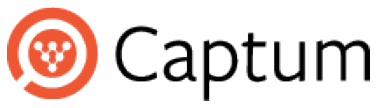


The RGBA image's alpha channel (white represents opaque 
regions, and black represents transparent regions):


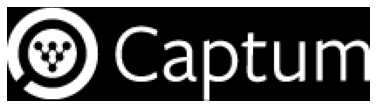


Our custom background image:


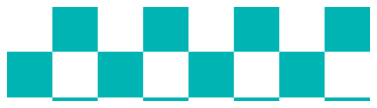


The RGBA image on top of the background image:


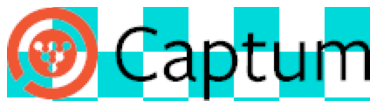

In [66]:
# Download RGBA & show test image
img_url = (
    "https://github.com/pytorch/captum/raw/master/website/static/img/captum_logo.png"
)
captum_logo = opt.images.ImageTensor.open(img_url, mode="RGBA")[None, :].to(device)

print("The RGBA image:")
opt.images.show(captum_logo, figsize=(6.5, 6.5))

# Show Captum logo with alpha channel only
print("\nThe RGBA image's alpha channel (white represents opaque \nregions, and black"
      + " represents transparent regions):")
opt.images.show(composite_alpha_only(captum_logo), figsize=(6.5, 6.5))

# Setup a checkerboard background image with square tiles
background = create_checkerboard([max(captum_logo.shape[2:])] * 2, tiles=4).to(device)
background = background[None, :, : captum_logo.shape[2], : captum_logo.shape[3]]

# Make black background tiles blue
blue_color = torch.tensor([0.0, 0.7071, 0.7071], device=device).view(1, 3, 1, 1)
background = torch.where(background == 0.0, blue_color, background)

# Show background image
print("\nOur custom background image:")
opt.images.show(background, figsize=(6.5, 6.5))

# Composite logo onto background
captum_logo_on_background = composite_alpha(
    captum_logo, background, gamma_to_linear=True
)
print("\nThe RGBA image on top of the background image:")
opt.images.show(captum_logo_on_background, figsize=(6.5, 6.5))

### Basic Optimization Without Transparency

Below we'll start off by performing feature visualization without any sort of transparency.

  0%|          | 0/512 [00:00<?, ? step/s]

  0%|          | 0/256 [00:00<?, ? step/s]

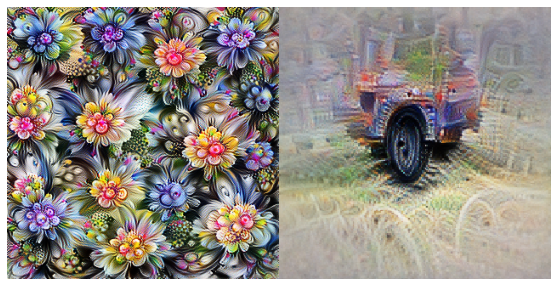

In [ ]:
# Set channel optimization target & render visualization
loss_fn = opt.loss.ChannelActivation(model.mixed4d.conv_3x3_reduce, channel_index=139)
image = opt.images.NaturalImage((320, 320), channels=3).to(device)
img_channel, _ = visualize(model, loss_fn, image, n_iter=512, lr=0.02)

# Set neuron optimization target & render visualization
loss_fn = opt.loss.NeuronActivation(model.mixed4b, channel_index=373)
image = opt.images.NaturalImage((200, 200), channels=3).to(device)
img_neuron, _ = visualize(model, loss_fn, image, n_iter=256, lr=0.01)

# Show both visualizations side by side
img_neuron = F.interpolate(img_neuron, size=(320, 320))
img_no_alpha = torch.cat([img_channel, img_neuron])
opt.images.show(img_no_alpha, figsize=(10, 5))

Looking at the above flower and car tire visualizations, we have no way of determining the importance of each part of the visualization. For example, we cannot easily tell what part of the flower is most important or how important the car body and ground are for tire detection.

This limitation of feature visualization may seem like something unavoidable, however it can be overcome with some clever design!

**Optimizing Additional Degrees of Freedom**

* Feature visualization can yield a ton of information about a target, but by default is unable to work with some of the additional degrees of freedom that targets can have. One such area is the importance or saliency of each part of the visualization. In the case of a model trained on 3 channel RGB images, we can view this additional dimension by adding a 4th channel for alpha transparency to our image parameterization. 

## Alpha Channel / Transparency

**Optimizing With The Additional Alpha Channel**

* Using the 4 channel RGBA image parameterization allows us to see the feature importance based on opacity. The more opaque something is, the more important it is. The more transparent something is, the less important it is.

* The optim module has been designed so that using RGBA images is just as easy as RGB images. For example, `NaturalImage()` handles RGBA images without any changes, other than being initialized with `channels=4`.

* To render a 4 channel visualization using a model that only supports 3 channels, we can use Captum's `BlendAlpha()` on our model input as the final transform. The `BlendAlpha()` transform performs [alpha composing](https://en.wikipedia.org/wiki/Alpha_compositing) which turns the 4 channel RGBA image into a 3 channel RGB image.

### Basic optimization with transparency


For basic optimization with transparency, we use a simple self balancing equation that avoids producing too much transparency or too much opaqueness:

```
loss_fn = LossFunction * (1.0 - mean(alpha_channel))
```

The above equation's alpha channel portion can be performed by using Captum's `opt.loss.ChannelLoss` objective with a channel index of `4` for the alpha channel and `opt.images.NaturalImage` as the target. This is demonstrated below.

  0%|          | 0/512 [00:00<?, ? step/s]

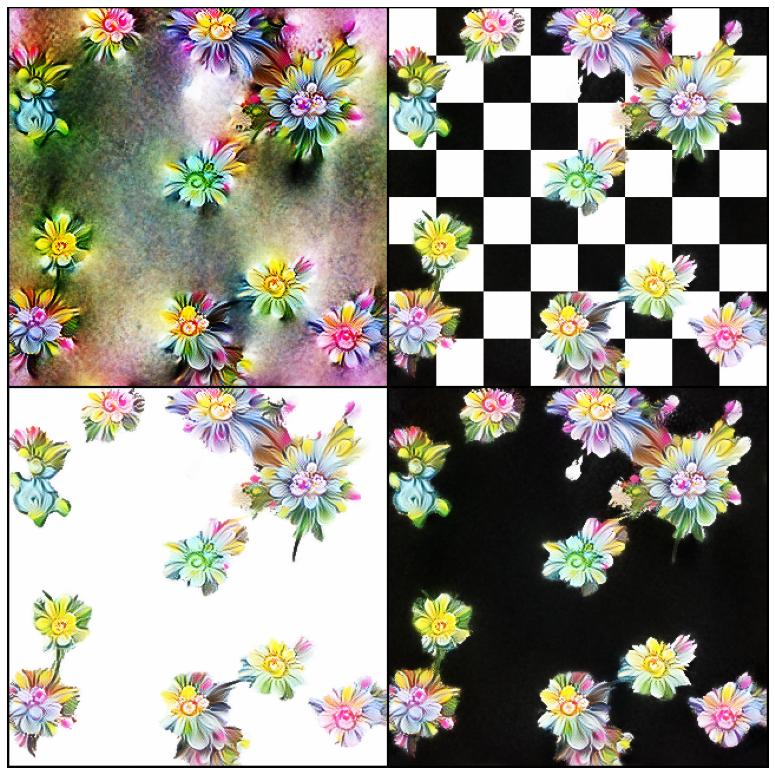

In [58]:
image_size = (320, 320)

# Initialize NaturalImage with 4 channels
image = opt.images.NaturalImage(image_size, channels=4).to(device)

# Set optimization target
loss_fn = opt.loss.ChannelActivation(model.mixed4d.conv_3x3_reduce, channel_index=139)

#  Use NaturalImage output as target, and collect alpha channel for mean()
loss_fn = loss_fn * (1.0 - opt.loss.ChannelActivation(image, channel_index=3))

# Blend the alpha channel into the image as our final transform
transforms = [opt.transforms.TransformationRobustness(), opt.transforms.BlendAlpha()]

# Render the visualization
img_basic, history_basic = visualize(
    model, loss_fn, image, transforms=transforms, n_iter=512
)

# Show visualization on multiple backgrounds
# The backgrounds are as follows: No transparency, checkerboard, white, & black
opt.images.show(create_mosaic(img_basic), images_per_row=2, figsize=(14, 14))

By placing our rendered image onto different backgrounds, we can clearly see the varying degrees of transparency throughout the image.

While this naive strategy works pretty well, the channel visualization features are positioned all over the rendered image when using the `ChannelActivation` loss objective for model targets. In the next section, we'll demonstrate a potential improvement by using a custom optimization loss objective.

We can also see that the optimization process is working well with our setup, by using the `plot_loss` helper function on the `history` output of `InputOptimization`'s `optimize` function.

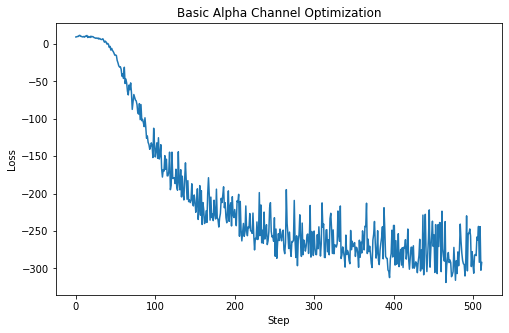

In [63]:
# Plot loss vs iterations
plot_loss(history_basic, title="Basic Alpha Channel Optimization", figsize=(8,5))

## Advanced optimization with transparency


While the simple optimization above using `opt.loss.ChannelActivation` works for optimizing the alpha channel, we can do better in a variety of ways. For example, using `NaturalImage` as a target means that we miss out on the random image transforms that can improve visualization quality.

Below we define a special loss objective for optimizing our alpha channel, using transform robustness. We also add a `CenterCrop()` transform to encourage the visualization to avoid the edges of the image.

In [4]:
@opt.loss.loss_wrapper
class AlphaChannelLoss(opt.loss.BaseLoss):
    """
    Optimize the alpha channel of an image parameterization.
    """

    def __init__(
        self,
        target: torch.nn.Module,
        crop_size: Tuple[int, int],
        scale_list: List[float],
        scale: int = 1.0,
        batch_index: Optional[int] = None,
    ) -> None:
        """
        Args:

            crop_size (Tuple[int, int]): The desired random crop size to use.
            scale_list (list of float): A list of scale values to randomly select from
                when rescaling the input.
            scale (float, optional): The maximum value in the image value range.
                Default: 1.0
            batch_index (int, optional): The target batch index to use.
                Default: None
        """
        opt.loss.BaseLoss.__init__(self, target, batch_index)
        assert len(crop_size) == 2
        self.random_scale = opt.transforms.RandomScale(scale_list)
        self.random_crop = opt.transforms.RandomCrop(crop_size=crop_size)
        self.scale = scale

    def __call__(self, targets_to_values: ModuleOutputMapping) -> torch.Tensor:
        activations = targets_to_values[self.target]
        activations = activations[self.batch_index[0] : self.batch_index[1], :, ...]
        assert activations.dim() == 4
        assert activations.shape[1] == 4

        alpha_mean = activations[:, 3:, ...].clone().mean()

        # Randomly scale the image and then randomly crop it
        scaled_alpha = self.random_scale(activations[:, 3:, ...].clone())
        cropped_alpha_mean = self.random_crop(scaled_alpha).mean()
        
        loss = (self.scale - alpha_mean) * (self.scale / 2)
        return loss + (self.scale - cropped_alpha_mean)

Now we can render the results using the `AlphaChannelLoss()` objective!

  0%|          | 0/512 [00:00<?, ? step/s]

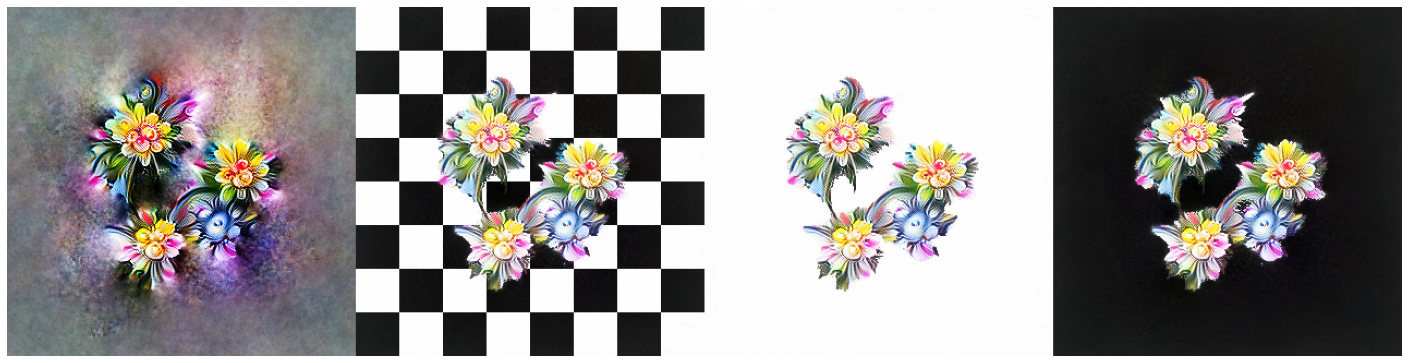

In [ ]:
image_size = (320, 320)
crop_size = (160, 160)
scale_list = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1]

# Initialize NaturalImage with 4 channels
image = opt.images.NaturalImage(image_size, channels=4).to(device)

# Set optimization target
loss_fn = opt.loss.ChannelActivation(model.mixed4d.conv_3x3_reduce, channel_index=139)

#  Use NaturalImage output as target, for alpha channel loss objective
loss_fn = loss_fn * AlphaChannelLoss(image, crop_size=crop_size, scale_list=scale_list)


# Setup basic transforms
transforms = [opt.transforms.TransformationRobustness()]
# Blend the alpha channel into the image using random backgrounds &
transforms = transforms + [opt.transforms.BlendAlpha()]
# Center crop the image to encourage visualizations in the image center
transforms = transforms + [opt.transforms.CenterCrop(crop_size)]

# Render visualization
img_advanced, history_advanced = visualize(
    model, loss_fn, image, transforms=transforms, n_iter=512
)

# Show visualization on multiple backgrounds
# The backgrounds are as follows: No transparency, checkerboard, white, & black
opt.images.show(create_mosaic(img_advanced), figsize=(25, 10))

  0%|          | 0/512 [00:00<?, ? step/s]

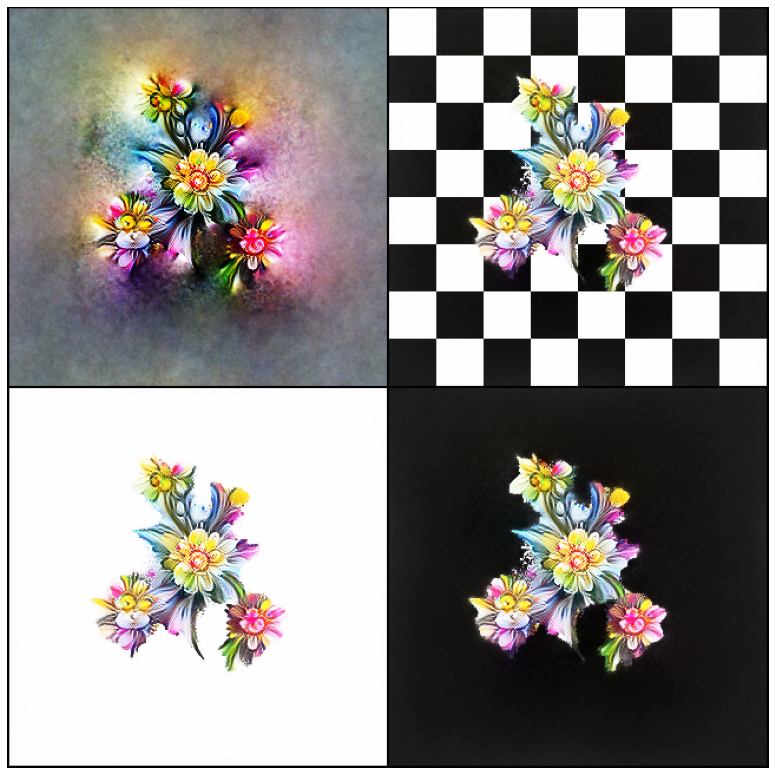

In [49]:
image_size = (320, 320)
crop_size = (150, 150)
scale_list = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1]

# Initialize NaturalImage with 4 channels
image = opt.images.NaturalImage(image_size, channels=4).to(device)

# Set optimization target
loss_fn = opt.loss.ChannelActivation(model.mixed4d.conv_3x3_reduce, channel_index=139)

#  Use NaturalImage output as target, for alpha channel loss objective
loss_fn = loss_fn * AlphaChannelLoss(image, crop_size=crop_size, scale_list=scale_list)


# Setup basic transforms
transforms = [opt.transforms.TransformationRobustness()]
#transforms[0].random_scale.antialias = True
# Blend the alpha channel into the image using random backgrounds &
transforms = transforms + [opt.transforms.BlendAlpha()]
# Center crop the image to encourage visualizations in the image center
transforms = transforms + [opt.transforms.CenterCrop(crop_size)]

# Render visualization
img_advanced, history_advanced = visualize(
    model, loss_fn, image, transforms=transforms, n_iter=512
)

# Show visualization on multiple backgrounds
# The backgrounds are as follows: No transparency, checkerboard, white, & black
#opt.images.show(create_mosaic(img_advanced), images_per_row=2, figsize=(25, 20))
opt.images.show(create_mosaic(img_advanced), images_per_row=2, figsize=(14, 14))

The visualization is now nicely centered in the images.

We can also easily visualize the alpha channel as white regions on a black background like this.

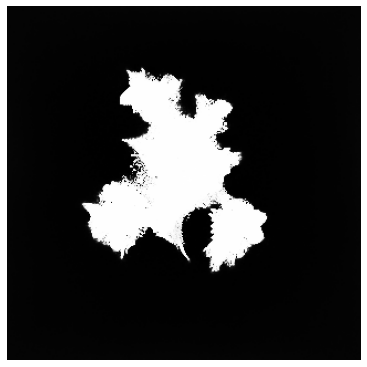

In [50]:
opt.images.show(composite_alpha_only(img_advanced), figsize=(6.5, 6.5))

When we look at the history graph, we can see that the optimization process performed even better with our improved `AlphaChannelLoss()` objective!

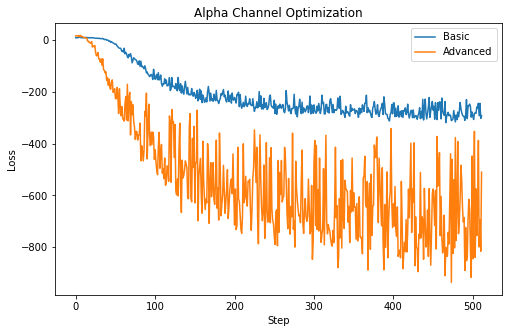

In [64]:
# Plot loss vs iterations & previous loss
plot_loss(
    history=[history_basic, history_advanced],
    title="Alpha Channel Optimization",
    labels=["Basic", "Advanced"],
    figsize=(8,5),
)

## Two Stage Optimization with Transparency

In addition to using the `BlendAlpha()` transform for RGBA images, we can also simply cut off and ignore the alpha channel by using the `IgnoreAlpha()` transform. This is useful for example when we want to ignore the alpha channel for the first step of two step optimization, so that the first stage of optimization occurs without the influence of the alpha channel.

We can then perform two stage optimization with transparency like so.

We render stage 1 without the alpha channel using the `IgnoreAlpha()` transform.

In [ ]:
image_size = (112, 112)

# Initialize NaturalImage with 4 channels
image = opt.images.NaturalImage(image_size, channels=4).to(device)

# Other targets to explore
# target=model.mixed3a.conv_3x3; channel_index=76
# target=model.mixed3a.conv_3x3_reduce_relu; channel_index=76 - 64
# target=model.mixed4d.conv_3x3_reduce; channel_index=139

# Car Tire
target = model.mixed4b
channel_index = 373

# Set main optimization target
loss_fn = opt.loss.NeuronActivation(target, channel_index=channel_index)

# Basic transforms applied to both stages
basic_transforms = [opt.transforms.TransformationRobustness()]

# Ignore the alpha channel for stage 1
stage_one_transforms = basic_transforms + [opt.transforms.IgnoreAlpha()]

# Render stage 1 visualization
image, stage_one_history = visualize(
    model, loss_fn, image, transforms=stage_one_transforms, n_iter=256, return_image_instance=True
)
# Save a copy of the image parameterization in its current state
stage_one_img = image().clone().detach()

  0%|          | 0/256 [00:00<?, ? step/s]

We then render stage 2 with the alpha channel using the `BlendAlpha()` transform, using the same instance of `NaturalImage` as step 1.

In [ ]:
# Blend the alpha channel into the image for stage 2
stage_two_transforms = basic_transforms + [opt.transforms.BlendAlpha()]

# Setup Alpha channel optimization objective
loss_fn = loss_fn * (1.0 - opt.loss.ChannelActivation(stage_two_transforms[0], channel_index=3))

# Render stage 2 visualization with same NaturalImage instance as step 1
image, stage_two_history = visualize(
    model, loss_fn, image, transforms=stage_two_transforms, n_iter=512, return_image_instance=True
)
stage_two_img = image().detach()

  0%|          | 0/512 [00:00<?, ? step/s]

We can then compare the rendered visualizations from both stages.

Stage 1 Visualization (No Alpha Channel)


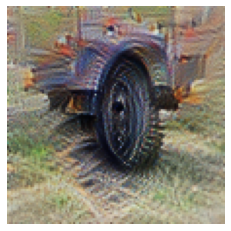

Stage 2 Visualization


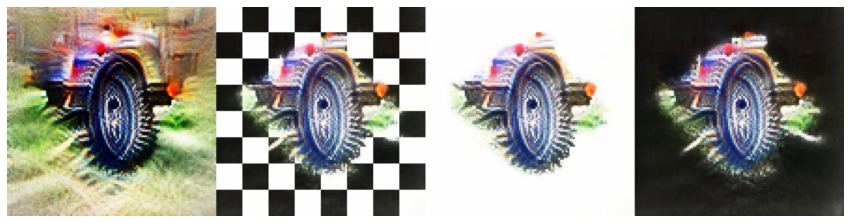

In [ ]:
# Show step 1 image without alpha channel
print("Stage 1 Visualization (No Alpha Channel)")
opt.images.show(stage_one_img[:, :3, ...])

# Show visualization on multiple backgrounds
print("Stage 2 Visualization")
opt.images.show(create_mosaic(stage_two_img), figsize=(15, 10))

And we can see the loss graph for both stages like so:

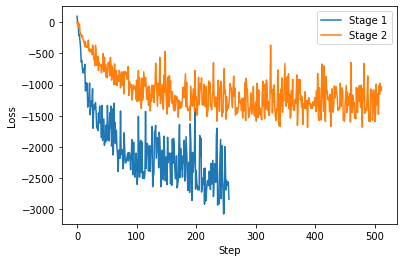

In [ ]:
# Plot loss vs iterations
plot_loss([stage_one_history, stage_two_history], labels=["Stage 1", "Stage 2"])

### Single Stage vs Two Stage Comparison

We can also see how single stage optimization compares to two stage optimization.

  0%|          | 0/512 [00:00<?, ? step/s]

Single Stage Visualization


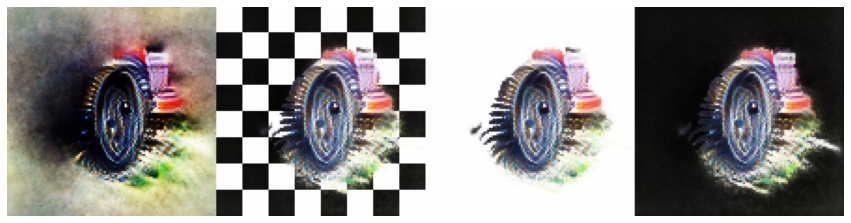

Two Stage Visualization


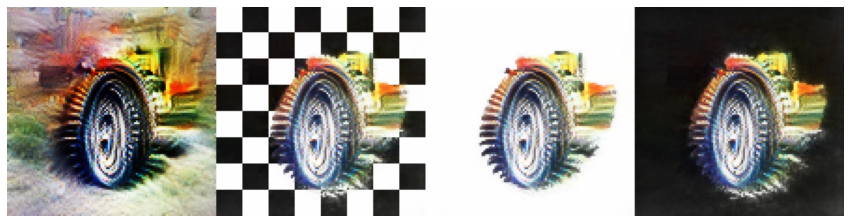

In [ ]:
image_size = (112, 112)

# Initialize NaturalImage with 4 channels
image = opt.images.NaturalImage(image_size, channels=4).to(device)

# Set optimization target
target = model.mixed4b
channel_index = 373

# Set optimization target
loss_fn = opt.loss.NeuronActivation(target, channel_index=channel_index)

# Setup transforms, & blend the alpha channel into the image using random backgrounds
transforms = [opt.transforms.TransformationRobustness(), opt.transforms.BlendAlpha()]

# Use transformed output as target
loss_fn = loss_fn * (1.0 - opt.loss.ChannelActivation(transforms[0], channel_index=3))


# Render visualization
neuron_img, history_advanced = visualize(
    model, loss_fn, image, transforms=transforms, n_iter=512
)

# Show single stage visualization on multiple backgrounds
print("Single Stage Visualization")
opt.images.show(create_mosaic(neuron_img), figsize=(15, 10))

# Show two stage visualization on multiple backgrounds
print("Two Stage Visualization")
opt.images.show(create_mosaic(stage_two_img), figsize=(15, 10))

You can see that using two stage visualization can help reveal important areas of the visualization that the single stage misses, while producing better quality visualizations.

## Optimization with alpha channel blur

In more recent research like [Goh, et al., "Multimodal Neurons in Artificial Neural Networks", Distill, 2021.](https://distill.pub/2021/multimodal-neurons/), alpha transparency optimization has been performed by using blurring penalties.

Below we define a blurring penalty objective called `BlurActivations`, and second penatly objective called `MeanAlphaChannelPenalty`.

In [ ]:
@opt.loss.loss_wrapper
class MeanAlphaChannelPenalty(opt.loss.BaseLoss):
    """
    Mean alpha channel loss penalty for optimizing with transparency.

    This objective essentually the the square root of the DeepDream objective, but
    only for the alpha channel. The square root of the output is then calculated.

    Basically the same as this, but for the alpha channel only:
        loss_fn = DeepDream(target) ** (1/2)

    Used in the https://distill.pub/2021/multimodal-neurons/ paper for optimizing with
    transparency, in the supplimentary code here:
    https://github.com/openai/CLIP-featurevis/blob/master/example_facets.py
    """

    def __init__(
        self,
        target: torch.nn.Module,
        batch_index: Optional[int] = None,
    ) -> None:
        """
        Args:

            target (nn.Module): A target layer instance.
            batch_index (int, optional): The index of activations to optimize if
                optimizing a batch of activations. If set to None, defaults to all
                activations in the batch.
                Default: None
        """
        opt.loss.BaseLoss.__init__(self, target, batch_index)

    def __call__(self, targets_to_values: ModuleOutputMapping) -> torch.Tensor:
        activations = targets_to_values[self.target]
        assert activations.dim() == 4 and activations.shape[1] == 4
        activations = activations[self.batch_index[0] : self.batch_index[1]]
        return torch.sqrt(torch.mean(activations[:, 3:] ** 2))


def _conv_blur(x: torch.Tensor, k: int = 3) -> torch.Tensor:
    """
    Blur an input tensor, as per the Lucid supplimentary code for
    Olah, et al., "Feature Visualization", Distill, 2017:
    https://distill.pub/2017/feature-visualization/

    See here for more details:
    https://github.com/tensorflow/lucid/blob/master/lucid/optvis/objectives.py#L261

    Args:

        x (torch.Tensor): A NCHW tensor to blur.
        k (int, optional): The desired filter height / width to use.

    Returns:
        x (torch.Tensor): A blurred version of the input tensor.
    """
    assert x.dim() == 4
    channels = x.shape[1]
    k = torch.zeros([channels, channels, k, k], device=x.device)
    for ch in range(channels):
        k_ch = k[ch, ch, :, :]
        k_ch[:, :] = 0.5
        k_ch[1:-1, 1:-1] = 1.0
    return F.conv2d(x, k, padding="same") / F.conv2d(
        torch.ones_like(x), k, padding="same"
    )


@opt.loss.loss_wrapper
class BlurActivations(opt.loss.BaseLoss):
    """
    This objective was used in early feature visualization research, and more recently
    for alpha channel optimiation.

    Used in the https://distill.pub/2021/multimodal-neurons/ paper for optimizing with
    transparency, in the supplimentary code here:
    https://github.com/openai/CLIP-featurevis/blob/master/example_facets.py

    See Nguyen, et al., 2015 for the origins of the idea:
    https://arxiv.org/abs/1412.1897
    """

    def __init__(
        self,
        target: torch.nn.Module,
        channel_index: Optional[int] = None,
        blur_fn: Optional[Callable] = None,
        batch_index: Optional[int] = None,
    ) -> None:
        """
        Args:

            target (nn.Module): A target layer instance.
            channel_index (int, optional): Optionally only blur a specific channel.
                If set to None, all channels with be blurred.
                Default: None
            blur_fn (Callable, optional): A function or class instance that blurs
                input tensors. If set to None, the _conv_blur function is used.
                Default: None
            batch_index (int, optional): The index of activations to optimize if
                optimizing a batch of activations. If set to None, defaults to all
                activations in the batch.
                Default: None
        """
        opt.loss.BaseLoss.__init__(self, target, batch_index)
        self.channel_index = channel_index
        self.blur_fn = blur_fn or _conv_blur

    def __call__(self, targets_to_values: ModuleOutputMapping) -> torch.Tensor:
        activations = targets_to_values[self.target]
        activations = activations[self.batch_index[0] : self.batch_index[1]]
        if self.channel_index is not None:
            activations = activations[:, self.channel_index : self.channel_index + 1]
        activations_blurred = self.blur_fn(activations.detach())
        return 0.5 * torch.sum((activations - activations_blurred) ** 2)

We render the results using our custom loss objectives.

  0%|          | 0/512 [00:00<?, ? step/s]

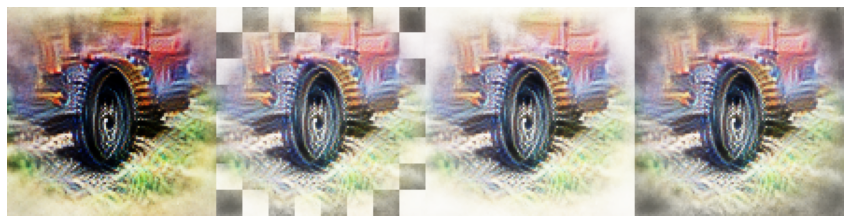

In [ ]:
image_size = (112, 112)

# Initialize NaturalImage with 4 channels
image = opt.images.NaturalImage(image_size, channels=4).to(device)

# Set optimization target
target = model.mixed4b
channel_index = 373

# Setup main loss objective
loss_fn = opt.loss.NeuronActivation(target, channel_index=channel_index)

# Setup transforms, & blend the alpha channel into the image using random backgrounds
transforms = [
    opt.transforms.TransformationRobustness(),
    torch.nn.Identity(),
    opt.transforms.BlendAlpha(),
]

# Use transformed output as target for additional loss objectives
loss_fn = loss_fn - MeanAlphaChannelPenalty(transforms[0])
loss_fn = loss_fn - (10 * BlurActivations(transforms[1], channel_index=3))


# Render visualization
neuron_img, history_advanced = visualize(
    model, loss_fn, image, transforms=transforms, n_iter=512
)


# Show results
opt.images.show(create_mosaic(neuron_img), figsize=(15, 10))

We can also see that the alpha channel for this visualization is rather different than what is produced by other alpha channel optimization strategies.

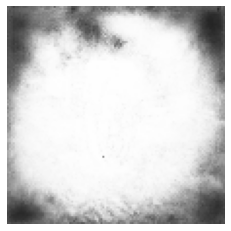

In [ ]:
opt.images.show(composite_alpha_only(neuron_img), figsize=(4, 4))